In [6]:

#  Learning PDF using GAN
#  Dataset: India Air Quality Data (NO2 feature)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
import tensorflow as tf
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

# LOAD
df = pd.read_csv('/content/indiaweather.csv',
                 encoding='latin1',
                 low_memory=False)

# Use correct column name
df = df[['no2']].dropna()

x = df['no2'].values.reshape(-1, 1)

print("Data shape:", x.shape)



Data shape: (419509, 1)


In [10]:

# TRANSFORMATION PARAMETERS

roll_number = 102316021   # change if needed

a_r = 0.5 * (roll_number % 7)
b_r = 0.3 * ((roll_number % 5) + 1)

print("Transformation Parameters:")
print("a_r =", a_r)
print("b_r =", b_r)

# Apply transformation
z = x + a_r * np.sin(b_r * x)


Transformation Parameters:
a_r = 1.5
b_r = 0.6


Epoch 0 | D Loss: 0.6721 | G Loss: 0.6792
Epoch 500 | D Loss: 1.4711 | G Loss: 0.2532
Epoch 1000 | D Loss: 2.4082 | G Loss: 0.1302
Epoch 1500 | D Loss: 3.0273 | G Loss: 0.0873
Epoch 2000 | D Loss: 3.4977 | G Loss: 0.0657
Epoch 2500 | D Loss: 3.8782 | G Loss: 0.0526
Epoch 3000 | D Loss: 4.2049 | G Loss: 0.0439
Epoch 3500 | D Loss: 4.4965 | G Loss: 0.0376
Epoch 4000 | D Loss: 4.7659 | G Loss: 0.0329
Epoch 4500 | D Loss: 5.0172 | G Loss: 0.0293
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


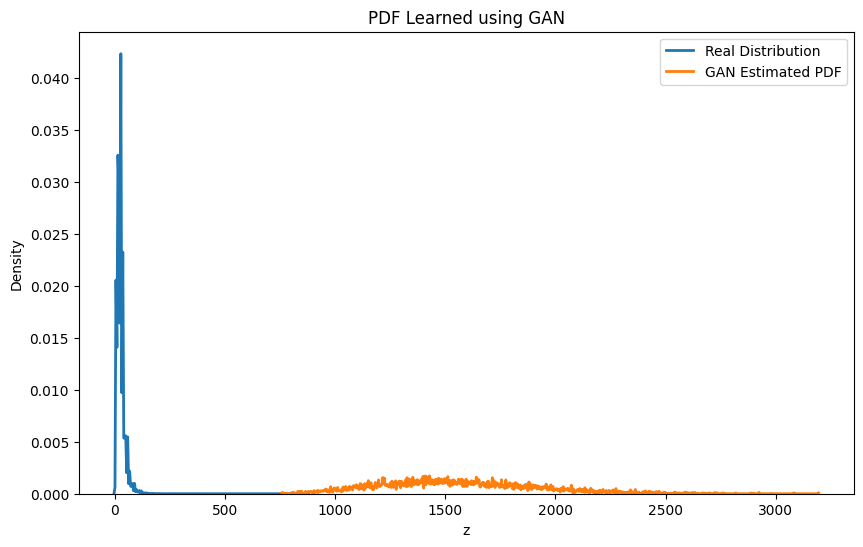

In [8]:


# BUILD GAN


latent_dim = 5

# GeneratoR
def build_generator():
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_dim=latent_dim),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    return model

#  Discriminator
def build_discriminator():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_dim=1),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(0.0002),
        metrics=['accuracy']
    )
    return model

generator = build_generator()
discriminator = build_discriminator()

#  Combined GAN
discriminator.trainable = False

gan_input = layers.Input(shape=(latent_dim,))
fake_sample = generator(gan_input)
gan_output = discriminator(fake_sample)

gan = models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(0.0002))

#  TRAIN GAN

epochs = 5000
batch_size = 128
half_batch = batch_size // 2

for epoch in range(epochs):


# Train Discriminator
    idx = np.random.randint(0, z_scaled.shape[0], half_batch)
    real_samples = z_scaled[idx]

    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss[0]:.4f} | G Loss: {g_loss:.4f}")

#  GENERATE LARGE SAMPLE FROM GENERATOR

n_samples = 10000
noise = np.random.normal(0, 1, (n_samples, latent_dim))
generated_scaled = generator.predict(noise)

generated = scaler.inverse_transform(generated_scaled)

#  PDF ESTIMATION USING KDE


kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(generated)

z_range = np.linspace(generated.min(), generated.max(), 1000).reshape(-1, 1)
log_density = kde.score_samples(z_range)
density = np.exp(log_density)
#  PLOT PDF


plt.figure(figsize=(10,6))

# Real distribution
sns.kdeplot(z.flatten(), label='Real Distribution', linewidth=2)

# GAN estimated PDF
plt.plot(z_range, density, label='GAN Estimated PDF', linewidth=2)

plt.title("PDF Learned using GAN")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()


In [9]:
generator.summary()
discriminator.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,241 (8.75 KB)